In [1]:
import scipy as sp
import os
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn import linear_model
import plotly.express as px
import plotly


import japanize_matplotlib
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# 乱数seedの固定
np.random.seed(seed=123)

/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/japanize_matplotlib/__init__.py:13: MatplotlibDeprecationWarning:


The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.



In [2]:
# E-step
def EStep(k_size, y, lambda_vec, coef_vec, sigma2_vec):
    '''
    y[i]
    lambda[k]
    mu[k]
    sigma[k]
    '''
    I = len(y)
    # 中身を初期化せずに配列を作成する関数である。
    # 2行, 1000列の配列を生成
    responsibility = sp.empty((k_size, I))
    
    for k in sp.arange(k_size):
        norm = stats.norm(loc=np.mean(X@coef_vec[k]), scale=sp.sqrt(sigma2_vec[k]))
        responsibility[k] = lambda_vec[k] *norm.pdf(y)

    responsibility = responsibility / sp.sum(responsibility, axis=0)
    return responsibility

def MStep(k_size, responsibility, y):

    lambda_vec = sp.empty(k_size)
    #mu_vec = sp.empty(k_size)
    coef_vec = []
    sigma2_vec = sp.empty(k_size)
    

    for k in sp.arange(k_size):
        r_k = responsibility[k]
        
        #coef_vec[k] = np.linalg.inv(X.T @ np.diag(r_k) @ X) @ X.T @np.diag(r_k)@y
        coef_vec.append(np.linalg.inv(X.T @ np.diag(r_k) @ X) @ X.T @np.diag(r_k)@y)
        
        #lambda_vec[k] = sp.sum(r_k) / sp.sum(responsibility)
        lambda_vec[k] = sp.sum(r_k) / responsibility.shape[1]
        
        #mu_vec[k] = sp.sum(r_k * y) / sp.sum(r_k)
        
        sigma2_vec[k] = sp.sum(r_k * (y - np.mean(X@coef_vec[k]))**2) / sp.sum(r_k)
        
    mu_vec = [np.mean(X@coef_vec[0]), np.mean(X@coef_vec[1])]
        
        
        

    return lambda_vec, mu_vec, coef_vec, sigma2_vec

In [3]:
def calc_mix_pdf(k_size, x, lambda_vec, coef_vec, sigma2_vec):
    pdf = sp.zeros_like(x)

    for k in sp.arange(k_size):
        norm_k = stats.norm(loc=np.mean(X@coef_vec[k]), scale=sp.sqrt(sigma2_vec[k]))
        
        # pdf (Probability density function) 確率密度関数
        # xのときの値を取得
        pdf += lambda_vec[k] * norm_k.pdf(x)
    return pdf

In [4]:
def calc_log_likelihood(X, coef_vec, sigma2_vec, lambda_vec, y):
    norm1 = stats.norm(loc=X@coef_vec[0], scale=np.sqrt(sigma2_vec[0])).pdf(y)
    norm2 = stats.norm(loc=X@coef_vec[1], scale=np.sqrt(sigma2_vec[1])).pdf(y)
    likelihood=lambda_vec[0]*norm1 + lambda_vec[1]*norm2
    log_likelihood = np.sum(np.log(likelihood))
    return log_likelihood

# Config

In [518]:
# 　使用する変数
#FEATS = ["hf", "pop",  "urb", "gdp","dist", "air", "detection"]

FEATS = ['urb', 'gdp', 'air', 'detection', 'HDI', 'median_age', 'dist_italy']
exp_name = "exp21"
memo="重力モデル、dist/hf/popを除く、HDI/median_age/dist_italyを追加"

NEW_DIR_PATH = f'output/{exp_name}/'
os.mkdir(NEW_DIR_PATH)

# データの作成

In [519]:
#df = pd.read_excel("../../data/data_covid_fix_name.xlsx")
#df = pd.read_csv("../../data/data_covid_fix_name_code_coordinate_ltaly.csv").iloc[:,1:]
df = pd.read_csv("../../data/data_covid_fix_name_code_coordinate_ltaly_medianage_hdi_density.csv")
df = df.dropna().reset_index(drop=True)

In [520]:
df.head(2)

,country,pop,urb,gdp,dist,hf,pf,ef,date_first,detection,...,cumul,air,code3,code2,lat,lon,dist_italy,median_age,HDI,population_density
0,Albania,2866376,60.319,13364.155397,6.996524e+06,7.84,8.005411,7.67,70,74.3,...,108641,303.14,ALB,AL,41.327546,19.818698,613446.033335,36.200001,0.792,104.612263
1,Algeria,42228429,72.629,15481.787620,9.108277e+06,4.99,5.201489,4.77,58,12.0,...,80272,6442.44,DZA,DZ,36.753768,3.058756,993497.660060,27.500000,0.746,17.730075


In [521]:
y=np.log(df["date_first"]).values
#plt.hist(y, density=True)

(array([0.00707862, 0.06370761, 0.05662899, 0.14157247, 0.28314494,
        0.19112283, 0.17696559, 0.0920221 , 0.02831449, 0.00707862]),
 array([11.48000963, 12.4345394 , 13.38906917, 14.34359894, 15.29812871,
        16.25265847, 17.20718824, 18.16171801, 19.11624778, 20.07077755,
        21.02530731]),
 <a list of 10 Patch objects>)

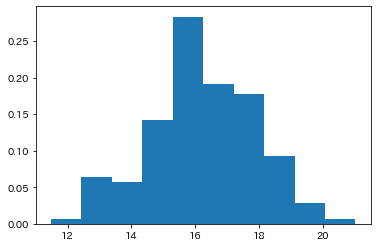

In [522]:
plt.hist(np.log(df["pop"]), density=True)

### スケーリング(標準化)

In [523]:
tmp = df[[ "date_first"]+FEATS]
tmp.index = df["country"]
tmp

,date_first,urb,gdp,air,detection,HDI,median_age,dist_italy
country,,,,,,,,
Albania,70,60.319,13364.155397,303.14,74.3,0.792,36.200001,6.134460e+05
Algeria,58,72.629,15481.787620,6442.44,12.0,0.746,27.500000,9.934977e+05
Angola,83,65.514,6452.355165,76.94,17.9,0.582,16.400000,5.618975e+06
Argentina,65,91.870,20610.568550,1516.63,74.9,0.842,30.799999,1.113159e+07
Australia,26,86.012,51663.365095,75667.65,97.3,0.943,37.400002,1.621597e+07
...,...,...,...,...,...,...,...,...
Venezuela,76,88.208,18102.500000,2137.77,8.7,0.733,27.400000,8.364562e+06
Vietnam,25,35.919,7447.814334,47049.67,57.4,0.700,30.400000,8.744323e+06
Yemen,102,36.642,2575.126385,336.31,9.0,0.468,19.200001,4.226779e+06


In [524]:
X = np.log(df[FEATS])
#X["population_density"] = np.log(X["population_density"])
#X["air"] = np.log(X["air"])
sscaler = preprocessing.StandardScaler() # インスタンスの作成

sscaler.fit(X)    
X = sscaler.transform(X) # xを変換
pd.DataFrame(X, columns=FEATS)

,urb,gdp,air,detection,HDI,median_age,dist_italy
0,0.136279,0.003753,-0.702490,0.984823,0.443805,0.766565,-1.070980
1,0.550802,0.127258,0.425582,-2.180751,0.182704,-0.107690,-0.768912
2,0.320680,-0.607634,-1.208557,-1.486427,-0.900588,-1.751744,0.316633
3,1.075349,0.367519,-0.108257,0.998787,0.710940,0.252760,0.744943
4,0.928286,1.139126,1.334783,1.453074,1.205279,0.870289,0.980644
...,...,...,...,...,...,...,...
143,0.984557,0.258569,0.018437,-2.739106,0.105992,-0.119277,0.565895
144,-1.020756,-0.487163,1.159417,0.536750,-0.095020,0.211184,0.593713
145,-0.976274,-1.378907,-0.664166,-2.680244,-1.851867,-1.250393,0.138259
146,-0.592259,-0.963388,-2.004647,-1.136246,-0.900588,-1.618805,0.412505


In [525]:
# データを早期、晩期に分割
y_early = df["date_first"][df["date_first"]<40]
y_late = df["date_first"][df["date_first"]>40]

x_early = X[df["date_first"]<40]
x_late = X[df["date_first"]>40]

# 初期値の設定  
- Rで計算済み

In [526]:
clf_early = linear_model.LinearRegression()
clf_early.fit(x_early, y_early)
# 決定係数
print("早期感染国の決定係数：", clf_early.score(x_early, y_early))

早期感染国の決定係数： 0.3777634510787814


In [527]:
clf_late = linear_model.LinearRegression()
clf_late.fit(x_late, y_late)
 
# 決定係数
print("晩期感染国の決定係数：", clf_late.score(x_late, y_late))

晩期感染国の決定係数： 0.5441128323765725


In [528]:
# 早期感染国のβ
coef1_first=[clf_early.intercept_] + list(clf_early.coef_)
#coef1_first=[1 for i in range(len(FEATS)+1)]

# 晩期感染国のβ
coef2_first=[clf_late.intercept_] + list(clf_late.coef_)
#coef2_first=[1 for i in range(len(FEATS)+1)]



first_df = pd.DataFrame(coef1_first, columns=["早期感染国β(初期値)"], index=["Intercept"]+ FEATS)
first_df["晩期感染国β(初期値)"] = coef2_first
first_df

,早期感染国β(初期値),晩期感染国β(初期値)
Intercept,32.193838,68.821799
urb,1.107990,-2.065095
gdp,-4.619999,-2.213927
air,-3.940539,-2.630309
detection,-0.589429,-2.424498
HDI,11.627787,-0.975041
median_age,-7.205801,1.504245
dist_italy,-1.097477,4.257348


### sigmaの初期値設定方法は要検討

In [529]:
# 切片の追加
X = np.insert(X, 0, 1, axis=1)

# muの初期値の計算
# mu = βx
mu1_first = np.mean(X@coef1_first)
mu2_first = np.mean(X@coef2_first)


# sigmaの初期値
sigma1_first = np.sum((y_early - np.mean(y_early))**2)/len(y_early)
sigma2_first = np.sum((y_late - np.mean(y_late))**2)/len(y_late)


In [530]:
# 混合正規分布の数
k_size = 2

# 混合比率
lambda_vec=[0.15, 0.85]

# 説明変数のパラメータ
mu_vec = [mu1_first, mu2_first]

# 分散(sigma)の初期値
sigma2_vec=[sigma1_first, sigma2_first]

# coefの初期値
coef_vec = [coef1_first, coef2_first]

In [531]:
print("f1の混合比率：", lambda_vec[0])
print("mu1：", mu_vec[0])
print("sigma1：", sigma2_vec[0])

f1の混合比率： 0.15
mu1： 32.19383759179379
sigma1： 27.16824196597353


In [532]:
print("f2の混合比率：", lambda_vec[1])
print("mu2：", mu_vec[1])
print("sigma2：", sigma2_vec[1])

f2の混合比率： 0.85
mu2： 68.82179932088708
sigma2： 100.12889600000001


### 初期値から生成される分布の確認

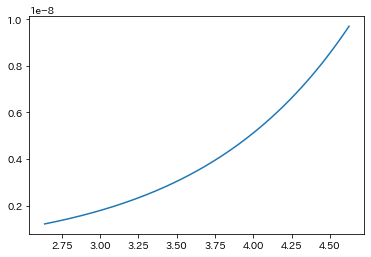

In [533]:
# データ(-6から6までを200こ)
x = sp.linspace(np.min(y), np.max(y), 150)
plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, coef_vec, sigma2_vec), label="ini")

plt.savefig(NEW_DIR_PATH +"初期値plot.png")

# EMアルゴリズム

-34.10876724014962
i: 0 lambda [0.995 0.005] mu [4.0923 4.0593] sigma2 [0.1441 0.1854]
-34.00395554967069
i: 1 lambda [0.9948 0.0052] mu [4.0927 4.0189] sigma2 [0.1435 0.2758]
-33.49204491918763
i: 2 lambda [0.9932 0.0068] mu [4.0945 3.9495] sigma2 [0.1405 0.5738]
-31.808942096186325
i: 3 lambda [0.9875 0.0125] mu [4.1001 3.915 ] sigma2 [0.131  0.9056]
-30.005422338805516
i: 4 lambda [0.9785 0.0215] mu [4.1067 3.9033] sigma2 [0.1211 0.8784]
-28.30036467545859
i: 5 lambda [0.9665 0.0335] mu [4.1131 3.8962] sigma2 [0.1129 0.7458]
-26.346474193839086
i: 6 lambda [0.9506 0.0494] mu [4.1207 3.8925] sigma2 [0.1045 0.6274]
-23.729690715966097
i: 7 lambda [0.9289 0.0711] mu [4.1311 3.891 ] sigma2 [0.0939 0.5367]
-19.30276794714514
i: 8 lambda [0.8985 0.1015] mu [4.147  3.8906] sigma2 [0.0791 0.4661]
-8.08483735043755
i: 9 lambda [0.8562 0.1438] mu [4.1729 3.8915] sigma2 [0.0572 0.4095]
19.83584018802067
i: 10 lambda [0.8066 0.1934] mu [4.2075 3.8977] sigma2 [0.0305 0.3672]
37.692999588639964
i

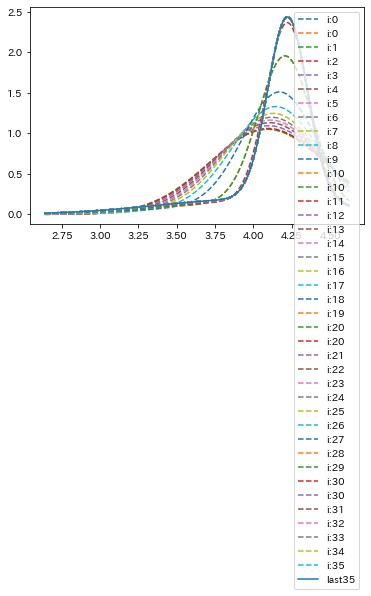

In [534]:
# 100回繰り返す
DIFF=0.000001
old=0
for i in sp.arange(100+1):
    # Estep # responsibilityの更新 
    responsibility = EStep(k_size, y, lambda_vec, coef_vec, sigma2_vec)
    
    # Mstep # 混合割合, 平均, 分散の更新
    lambda_vec, mu_vec, coef_vec, sigma2_vec = MStep(k_size, responsibility, y)
    plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, coef_vec, sigma2_vec), label=f"i:{i}", linestyle="--")
    
    log_likelihood = calc_log_likelihood(X, coef_vec, sigma2_vec, lambda_vec, y)
    print(log_likelihood)
    print("i:", i, "lambda", lambda_vec.round(4), "mu", np.round(mu_vec, 4), "sigma2", sigma2_vec.round(4))
    
    if i !=0:
        diff = abs(log_likelihood - old)
        if diff <DIFF:
            break
    old = log_likelihood

    if i % 10 == 0:
        #print("i:", i, "lambda", lambda_vec.round(4), "mu", np.round(mu_vec, 4), "sigma2", sigma2_vec.round(4))
        plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, coef_vec, sigma2_vec), label=f"i:{i}", linestyle="--")
        
plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, coef_vec, sigma2_vec), label=f"last{i}", linestyle="-")

plt.legend()
plt.tight_layout()
plt.savefig(NEW_DIR_PATH +"EMplot.png")
plt.show()

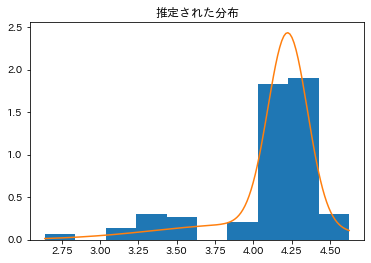

In [535]:
plt.hist(y, density=True)
plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, coef_vec, sigma2_vec), label="ini")
plt.title("推定された分布")
plt.savefig(NEW_DIR_PATH +"実測値と推定された分布.png")

#### 注  
- mu1, mu2は反転する可能性があるため、f1, f2の混合比率を確認

In [536]:
print("f1の混合比率：", lambda_vec[0])
print("mu1：", mu_vec[0])
print("sigma1", sigma2_vec[0])

print("f2の混合比率：", lambda_vec[1])
print("mu2：", mu_vec[1])
print("sigma2：", sigma2_vec[1])

f1の混合比率： 0.7344849767898032
mu1： 4.22399403586193
sigma1 0.016589925019980575
f2の混合比率： 0.2655150232101967
mu2： 3.9423383204600313
sigma2： 0.34026460061518476


###  推定された分布の可視化

Text(0.5, 1.0, '推定された分布の可視化')

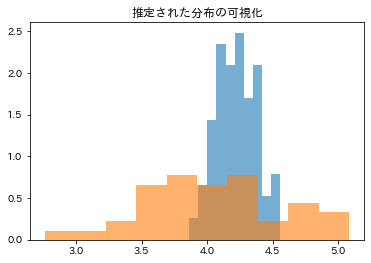

In [537]:
"""# 推定された分布の可視化
new_N1 = stats.norm(loc=mu_vec[0], scale=sp.sqrt(sigma2_vec[0]))
new_N2 = stats.norm(loc=mu_vec[1], scale=sp.sqrt(sigma2_vec[1]))

# rvs (Random variates) 確率変数
new_s1 = new_N1.rvs(size=int(lambda_vec[0]*150))
new_s2 = new_N2.rvs(size=int(lambda_vec[1]*150))


#plt.hist(y, bins=30, density=True)

plt.hist(new_s1, density=True, alpha=0.6)
plt.hist(new_s2, density=True, alpha=0.6)

"""
np.random.seed(seed=123)
new_s1 = np.random.normal(loc=mu_vec[0], scale=sp.sqrt(sigma2_vec[0]), size=int(lambda_vec[0]*150))
new_s2 = np.random.normal(loc=mu_vec[1], scale=sp.sqrt(sigma2_vec[1]), size=int(lambda_vec[1]*150))
plt.hist(new_s1, density=True, alpha=0.6)
plt.hist(new_s2, density=True, alpha=0.6)
plt.title("推定された分布の可視化")

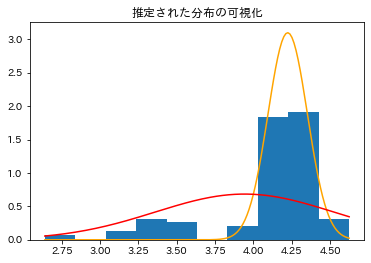

In [538]:
new_N1 = stats.norm.pdf(x, loc=mu_vec[0], scale=sp.sqrt(sigma2_vec[0]))
new_N2 = stats.norm.pdf(x, loc=mu_vec[1], scale=sp.sqrt(sigma2_vec[1]))

plt.hist(y, density=True,)
plt.plot(x, new_N1, color="orange")
plt.plot(x, new_N2, color="red")

plt.title("推定された分布の可視化")
plt.savefig(NEW_DIR_PATH +"分布1と2の可視化.png")

#### 推定されたパラメータ

In [539]:
res_df = pd.DataFrame(coef_vec[0].round(4), index=["Intercept"]+FEATS,  columns=["分布1"])
res_df["分布2"] = coef_vec[1].round(4)
res_df

,分布1,分布2
Intercept,4.2240,3.9423
urb,-0.0331,0.1561
gdp,-0.0406,-0.0391
air,-0.0325,-0.3244
detection,-0.0303,-0.0956
HDI,0.0149,0.0823
median_age,0.0050,-0.2140
dist_italy,0.0536,-0.0338


# AIC

In [540]:
"""norm1 = 1/(2*np.pi*sigma2_vec[0])**(1/2) * np.exp((-1/2) *((y - X@coef_vec[0]) **2/sigma2_vec[0]) )
norm2 = 1/(2*np.pi*sigma2_vec[1])**(1/2) * np.exp((-1/2) *((y - X@coef_vec[1]) **2/sigma2_vec[1]) )

likelihood = responsibility[0]@np.log(norm1) + responsibility[1]@np.log(norm2) + np.sum(responsibility[0]*np.log( lambda_vec[0])) + np.sum(responsibility[1]*np.log( lambda_vec[1]))
print("対数尤度", likelihood)"""

norm1 = stats.norm(loc=X@coef_vec[0], scale=np.sqrt(sigma2_vec[0])).pdf(y)
norm2 = stats.norm(loc=X@coef_vec[1], scale=np.sqrt(sigma2_vec[1])).pdf(y)
likelihood=lambda_vec[0]*norm1 + lambda_vec[1]*norm2
log_likelihood = np.sum(np.log(likelihood))
print("対数尤度", log_likelihood)


対数尤度 41.435376642441724


In [541]:
k=len(coef_vec[0])+2 + len(coef_vec[1])+2
aic = -2*(log_likelihood)+ 2 *(k)
print("AIC", aic)

AIC -42.87075328488345


# 決定係数

In [542]:
#y_hat = np.diag(responsibility[0])@X@coef_vec[0]*lambda_vec[0] + np.diag(responsibility[1])@X@coef_vec[1]*lambda_vec[1]
y_hat = (X@coef_vec[0])*lambda_vec[0] + (X@coef_vec[1])*lambda_vec[1]

In [543]:
from sklearn.metrics import r2_score
r2=r2_score( y, y_hat)
print("決定係数", r2)

決定係数 0.36411465388838726


In [544]:
df["y_hat"] = y_hat

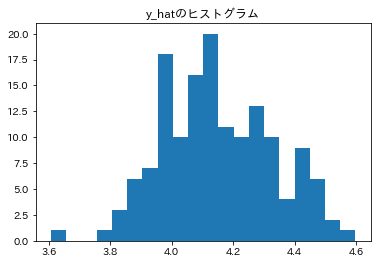

In [545]:
plt.hist(df["y_hat"], bins=20)
plt.title("y_hatのヒストグラム")
plt.savefig(NEW_DIR_PATH +"y_hatのヒストグラム.png")

In [546]:
df["y_hat"].describe()

count    148.000000
mean       4.149210
std        0.180335
min        3.607156
25%        4.014502
50%        4.125993
75%        4.278928
max        4.598028
Name: y_hat, dtype: float64

# その他評価指標

In [547]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y, y_hat))
rmse

0.3029048450286311

In [548]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y, y_hat)
mae

0.19789471370198508

# 残差の可視化

In [549]:
df["y-y_hat"] = df["date_first"] - df["y_hat"]
df[["country", "date_first", "y_hat", "y-y_hat"]].head()

,country,date_first,y_hat,y-y_hat
0,Albania,70,4.123016,65.876984
1,Algeria,58,4.198957,53.801043
2,Angola,83,4.456102,78.543898
3,Argentina,65,4.149641,60.850359
4,Australia,26,3.926273,22.073727


In [ ]:
# 実測値の可視化
fig =px.choropleth(
    df,
    locations="code3",
    color="date_first",
    hover_name="country",
    range_color=[0,102],
    #animation_frame='variable',
    #projection="natural earth",
    color_continuous_scale=list(reversed(px.colors.sequential.OrRd)),
                                )

fig.show()
#plotly.offline.plot(fig, filename='output/実測値の可視化.png')

In [ ]:
# 予測値の可視化
fig = px.choropleth(
    df,
    locations="code3",
    color="y_hat",
    hover_name="country",
    range_color=[0,102],
    #animation_frame='variable',
    #projection="natural earth",
    color_continuous_scale=list(reversed(px.colors.sequential.OrRd)),
                                )
fig.show()
plotly.offline.plot(fig, filename=NEW_DIR_PATH + "y_hatの可視化.html")

In [513]:
# 残差の可視化
fig = px.choropleth(
    df,
    locations="code3",
    color="y-y_hat",
    hover_name="country",
    #range_color=[0,102],
    #animation_frame='variable',
    #projection="natural earth",
    color_continuous_scale=list(reversed(px.colors.sequential.RdBu)),
                                )
plotly.offline.plot(fig, filename=NEW_DIR_PATH + "y_hatの可視化.html")
fig.show()

In [514]:
write_df = pd.DataFrame({
    "実験名":exp_name,
    "memo":memo,
    "説明変数":[FEATS],
    "分布1のβ":[coef_vec[0].round(4)],
    "分布2のβ":[coef_vec[1].round(4)],
    "混合比率":[lambda_vec.round(4)],
    "平均":[np.round(mu_vec, 4)],
    "分散":[np.round(sigma2_vec, 4)],
    "対数尤度":log_likelihood.round(4),
    "パラメータ数":k,
    "AIC":aic.round(4),
    "決定係数":r2.round(4),
    "RMSE":rmse.round(4),
    "MAE":mae.round(4)
})
write_df

,実験名,memo,説明変数,分布1のβ,分布2のβ,混合比率,平均,分散,対数尤度,パラメータ数,AIC,決定係数,RMSE,MAE
0,exp20,pop/hfを除く、HDI/median_age/dist_italyを追加,"[dist, urb, gdp, air, detection, HDI, median_a...","[60.5314, 10.7684, 0.4372, 0.9072, -2.5906, -5...","[68.4583, 0.9673, -2.9911, 0.0344, -1.6676, -2...","[0.403, 0.597]","[60.5314, 68.4583]","[628.2457, 67.3004]",-571.9342,22,1187.8684,0.4995,12.8474,9.5211


In [515]:
PATH="output/2成分混合回帰実験管理.xlsx"
excel_df = pd.read_excel(PATH)
excel_df = pd.concat([excel_df, write_df]).reset_index(drop=True)
excel_df.to_excel(PATH, sheet_name = "all", index=False)

#write_df.to_excel(PATH, sheet_name = exp_name)

In [516]:
FILE_NAME = "2成分混合回帰モデル_変数選択.ipynb"
f"{NEW_DIR_PATH}{FILE_NAME}"

'output/exp20/2成分混合回帰モデル_変数選択.ipynb'

In [517]:
!cp "2成分混合回帰モデル_変数選択.ipynb" 'output/exp20/2成分混合回帰モデル_変数選択.ipynb'

# t値

In [276]:
sse =  np.sum((y - y_hat) **2, axis=0)
sse = sse / (X.shape[0] - X.shape[1] -1 )
X_tmp = X-X.mean()
ss_ij = np.linalg.inv(X_tmp.T@X_tmp)
std_err2 = np.sqrt(np.diagonal(sse * ss_ij))
std_err2

print("std_err : ", std_err2)

std_err :  [1.58074003 1.50827569 2.22946661 2.17364351 1.61957918 1.68649391
 4.38710441 3.39265018]


In [277]:
t_value1 = coef_vec[0]/std_err2
t_value2 = coef_vec[1]/std_err2

# p値

In [278]:
from scipy import stats
p_values1 =[2*(1-stats.t.cdf(np.abs(i),(len(X)-len(X[0])))) for i in t_value1]
pd.DataFrame(np.round(p_values1, 3))

,0
0,0.000
1,0.664
2,0.629
3,0.673
4,0.570
5,0.534
6,0.055
7,0.238


In [279]:
from scipy import stats
p_values2 =[2*(1-stats.t.cdf(np.abs(i),(len(X)-len(X[0])))) for i in t_value2]
pd.DataFrame(np.round(p_values2, 3))

,0
0,0.000
1,0.000
2,0.299
3,0.522
4,0.001
5,0.161
6,0.499
7,0.761


In [280]:
res_df = pd.DataFrame(coef_vec[0].round(4), index=["Intercept"]+FEATS,  columns=["分布1"])
res_df["分布1_p値"] =np.round(p_values1, 4)
res_df["分布2"] = coef_vec[1].round(4)
res_df["分布2_p値"] =np.round(p_values2, 4)
res_df

,分布1,分布1_p値,分布2,分布2_p値
Intercept,26.6494,0.0000,68.6690,0.0000
pop,0.6565,0.6641,-9.6678,0.0000
urb,-1.0796,0.6290,-2.3227,0.2993
gdp,-0.9199,0.6728,-1.3965,0.5216
air,-0.9232,0.5696,5.3491,0.0012
detection,-1.0517,0.5339,-2.3792,0.1605
HDI,8.4942,0.0549,-2.9751,0.4988
median_age,-4.0207,0.2380,-1.0335,0.7611


In [141]:
import statsmodels.api as sm
  
model_early = sm.OLS(y_early, sm.add_constant(x_early))
result_early = model_early.fit()
result_early.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             date_first   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                 -0.176
Method:                 Least Squares   F-statistic:                    0.5888
Date:                Wed, 30 Dec 2020   Prob (F-statistic):              0.772
Time:                        20:56:31   Log-Likelihood:                -67.274
No. Observations:                  23   AIC:                             152.5
Df Residuals:                      14   BIC:                             162.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.5896      2.944      9.032      0.000      20.276      32.904
x1             0.7216      0.639      1.130      0.277      -0.648       2.091
x2            -1.6057      3.202     -0.501      0.624      -8.473       5.261
x3             1.8206      4.682      0.389      0.703      -8.222      11.863
x4            -1.1825      0.782     -1.512      0.153      -2.860       0.495
x5            -0.5281      2.236     -0.236      0.817      -5.324       4.268
x6            -3.5598      3.417     -1.042      0.315     -10.888       3.768
x7             5.8831      7.171      0.820      0.426      -9.498      21.264
x8            -0.6978      0.914     -0.764      0.458      -2.658       1.262
==============================================================================
Omnibus:                        1.004   Durbin-Watson:                   2.317
Prob(Omnibus):                  0.605   Jarque-Bera (JB):                0.797
Skew:                          -0.428   Prob(JB):                        0.671
Kurtosis:                       2.684   Cond. No.                         21.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [91]:
import statsmodels.api as sm
  
model_late = sm.OLS(y_late, sm.add_constant(x_late))
result_late = model_late.fit()
result_late.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             date_first   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     23.30
Date:                Mon, 07 Dec 2020   Prob (F-statistic):           2.69e-16
Time:                        18:32:51   Log-Likelihood:                -426.99
No. Observations:                 126   AIC:                             866.0
Df Residuals:                     120   BIC:                             883.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         68.9275      0.751     91.785      0.000      67.441      70.414
x1            -8.9373      2.156     -4.145      0.000     -13.206      -4.668
x2            -4.0466      0.865     -4.679      0.000      -5.759      -2.334
x3            -2.9779      0.948     -3.141      0.002      -4.855      -1.101
x4             4.9255      2.745      1.794      0.075      -0.509      10.360
x5            -3.2410      0.766     -4.234      0.000      -4.757      -1.725
==============================================================================
Omnibus:                        2.590   Durbin-Watson:                   2.105
Prob(Omnibus):                  0.274   Jarque-Bera (JB):                2.348
Skew:                           0.112   Prob(JB):                        0.309
Kurtosis:                       3.630   Cond. No.                         6.21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### ✅hf, pop, urb, gdp, air, detection, dist_itary

In [69]:
res_df

,分布1,分布2
Intercept,27.8169,68.9503
hf,2.1937,-0.9721
pop,0.3344,-9.8995
urb,-1.0413,-4.3070
gdp,0.4835,-1.9898
air,-0.6551,4.4905
detection,-1.0642,-2.5043
dist_italy,-2.3026,2.5252


In [111]:
k=len(coef_vec[0])+2 + len(coef_vec[1])+2
aic = -2*(log_likelihood)+ 2 *(k)
print("AIC", aic)

AIC 1169.1093682602955


/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.zeros_like is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros_like instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  after removing the cwd from sys.path.
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  """


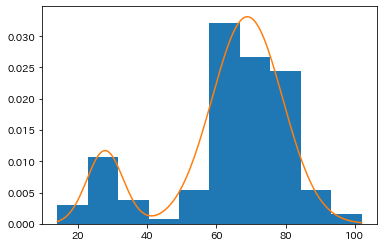

In [72]:
plt.hist(y, density=True)
plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, coef_vec, sigma2_vec), label="ini")

### ✅hf, pop, urb, gdp, air, dist

In [159]:
res_df

,早期感染国,晩期感染国
Intercept,60.2320,68.3693
hf,-6.7426,-1.8981
pop,-1.7336,-7.4032
urb,-4.9434,-4.0617
gdp,-0.5626,-1.3212
air,-3.4071,2.0536
dist,13.1993,1.7964


In [160]:
first_df

,早期感染国β(初期値),晩期感染国β(初期値)
Intercept,34.144527,68.705715
hf,-0.574947,-2.193724
pop,0.704297,-9.775305
urb,-1.465996,-4.893013
gdp,0.742538,-1.552997
air,-1.592736,3.112941
dist,7.020140,2.045302


/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.zeros_like is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros_like instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  after removing the cwd from sys.path.
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  """


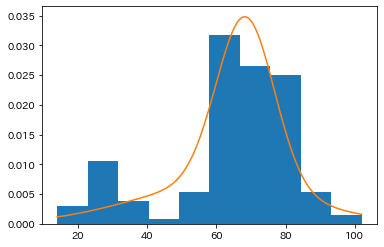

In [161]:
plt.hist(y, density=True)
plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, coef_vec, sigma2_vec), label="ini")

### ✅hf, pop, urb, gdp, air, detection

In [200]:
res_df

,早期感染国,晩期感染国
Intercept,27.6720,68.8998
hf,3.7881,-0.6450
pop,0.3898,-9.3063
urb,-0.2511,-4.0103
gdp,-0.1208,-2.8115
air,-0.6565,4.9016
detection,-2.4609,-2.9686


In [201]:
first_df

,早期感染国β(初期値),晩期感染国β(初期値)
Intercept,27.706694,68.924369
hf,3.847780,-0.651066
pop,0.389038,-9.473606
urb,-0.212951,-3.997060
gdp,-0.160500,-2.824348
air,-0.655912,5.035802
detection,-2.507140,-2.943951


/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.zeros_like is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros_like instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  after removing the cwd from sys.path.
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  """


Text(0.5, 1.0, '推定された分布')

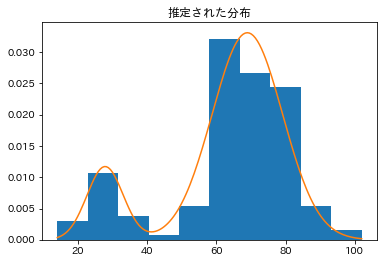

In [133]:
plt.hist(y, density=True)
plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, coef_vec, sigma2_vec), label="ini")
plt.title("推定された分布")

### ✅hf, pop, urb, gdp, air

In [134]:
res_df

,早期感染国,晩期感染国
Intercept,25.9985,68.8723
hf,2.2768,-1.9647
pop,0.5155,-10.5575
urb,-1.3567,-4.0571
gdp,1.1242,-2.8229
air,-0.9666,3.5627


In [135]:
first_df

,早期感染国β(初期値),晩期感染国β(初期値)
Intercept,26.053547,68.907071
hf,2.282413,-1.960874
pop,0.516722,-10.823974
urb,-1.277986,-4.032543
gdp,1.067690,-2.843152
air,-0.975720,3.781667


/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.zeros_like is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros_like instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  after removing the cwd from sys.path.
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  """


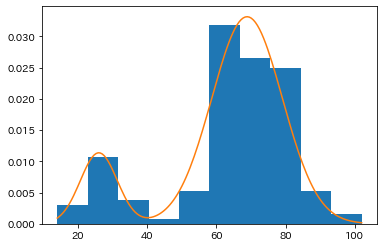

In [136]:
plt.hist(y, density=True)
plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, coef_vec, sigma2_vec), label="ini")

# 改善事項  
- p値  
- 信頼区間  
- AIC  
  
  
- 対数化しない場合  
- 変数選択  
- f1とf2で変数を帰る

# 散布図行列

In [116]:
data = df.copy()
data = data[["date_first", "hf", "pop",  "urb", "gdp","dist", "air", "detection"]]
data["flag"]=0
data.loc[data["date_first"]>40, "flag"]=1

/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


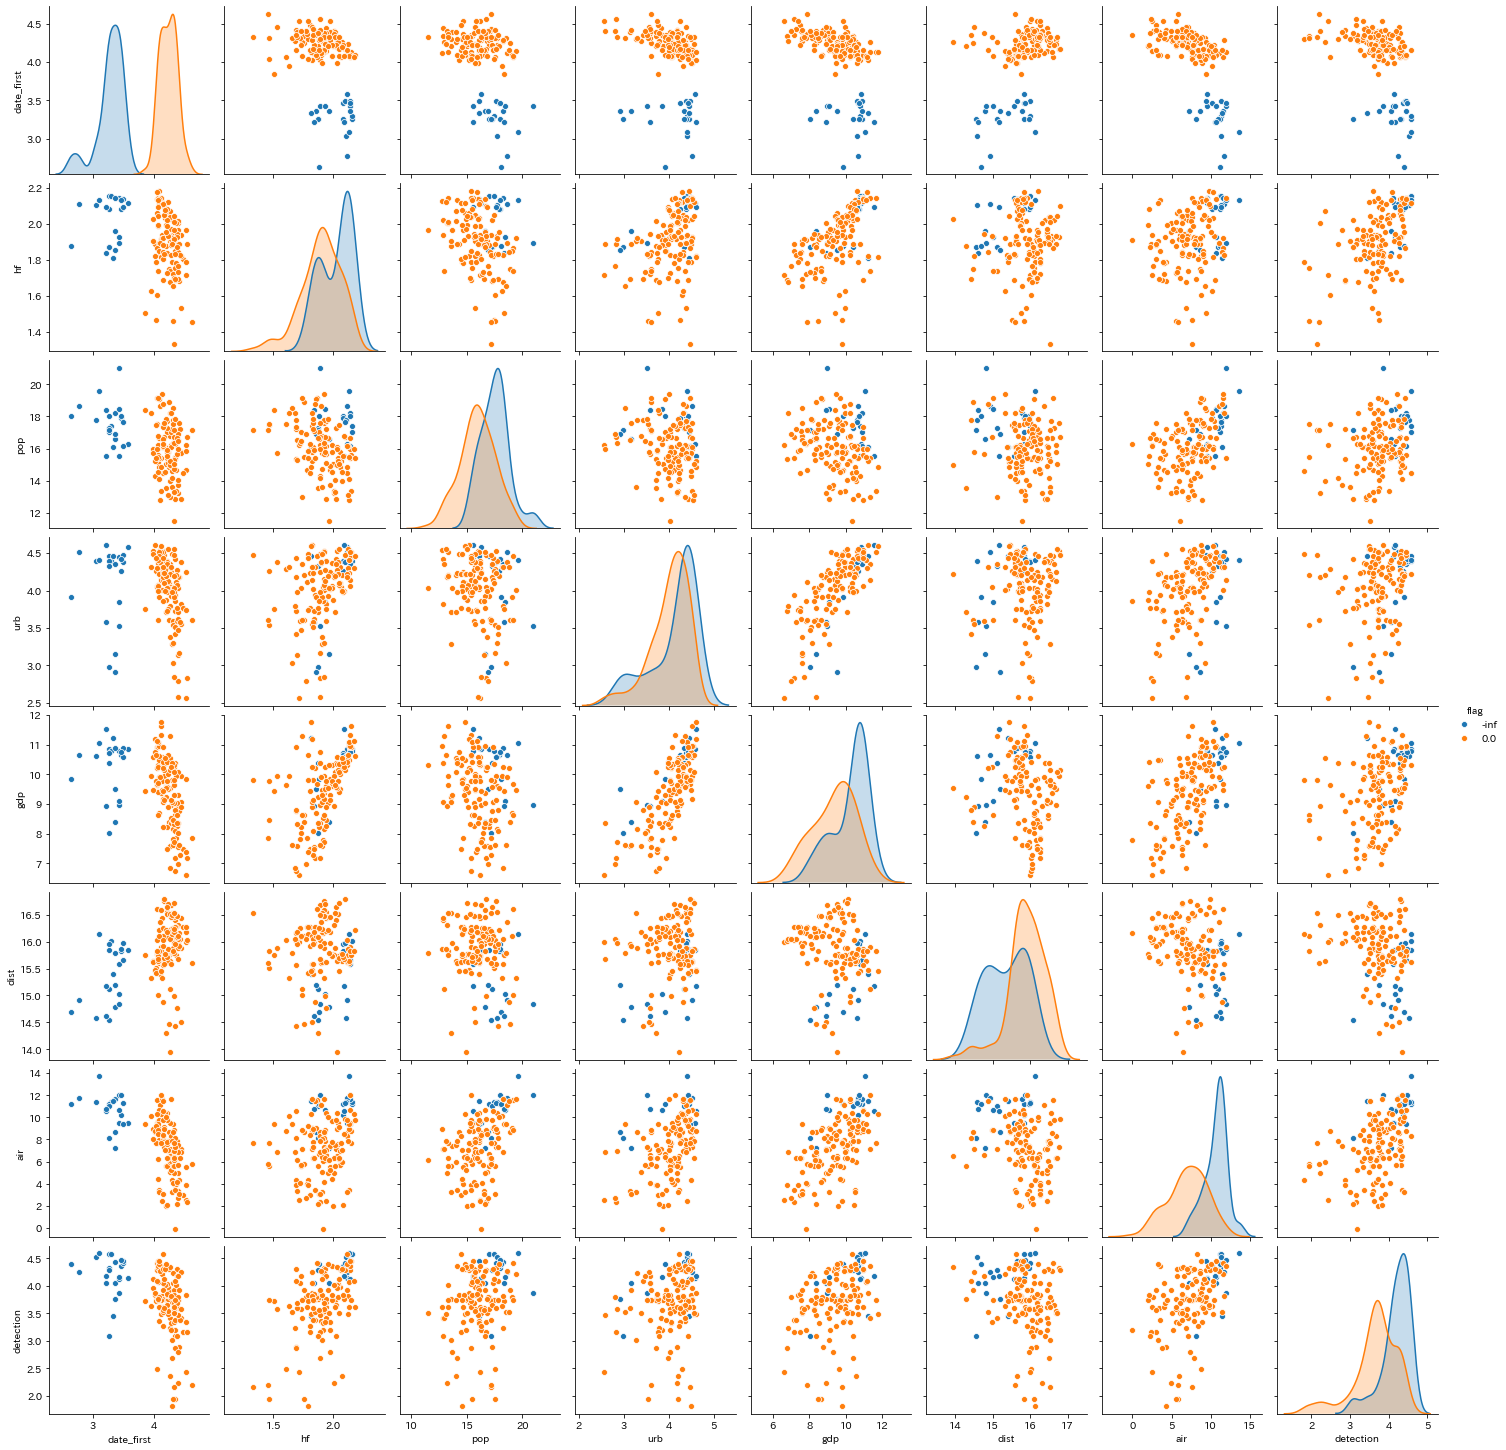

In [26]:
import seaborn as sns
sns.pairplot(np.log(data), hue='flag')